# Exercise containing best replica placement solution (in user-to-replica distance terms) and critical link set detection
Authors: Carlos Natalino, Marija Furdek and Amaro de Sousa

Paper used as basis: [IEEEXplore](https://ieeexplore.ieee.org/abstract/document/8489838)

In [1]:
# input definition

# definition of the topology used
topology = 'Germany50'
# topology = 'Coronet'

# budget for the RPP
budget = 4 # input: R

# pmin and pmax for the CLSD
pmin = 2
pmax = 12

export_format = 'svg' # you can set the format to pdf, png, eps, etc.

Germany50             |  Coronet
:-------------------------:|:-------------------------:
![](./results/Germany50_original.svg)  |  ![](./results/Coronet_original.svg)

In [2]:
import networkx as nx
import numpy as np
import datetime
import math

import matplotlib
import matplotlib.pyplot as plt

import reader
from cdn_functions import rpp_min_d, clsd

import sys

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger('matplotlib').setLevel(logging.FATAL)

from matplotlib import rcParams

lpsolve not supported
cplex supported


## Reading general inputs

In [3]:
fig_size = {}
fig_size['Coronet'] = (9, 6)
fig_size['Germany50'] = (6, 8)

graph = reader.read_file(f'./topologies/{topology}.txt', topology)

## Replica placement

The function `rpp_min_d` returns the values of the variables from the problem in the form of a Python dictionary.
It receives as input the graph and the budget, i.e., the number of DCs to be placed.
Consult the paper for more information.

In [4]:
variables_rpp = rpp_min_d(graph, budget)

done
found 11351 variables in the solution


### Visualizing the solution

/home/carda/.conda/envs/python36-cplex/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


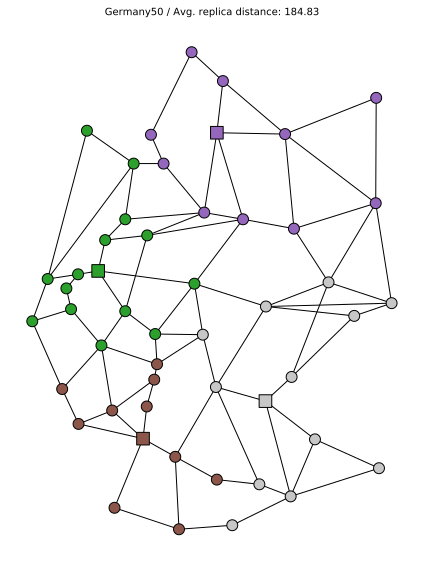

In [5]:
plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')
plt.axis('off')

plt.title('{} / Avg. replica distance: {:.2f}'.format(topology, variables_rpp['sum_distance'] / (graph.number_of_nodes() - budget)), fontsize=10)

# drawing only the network edges
nx.draw_networkx_edges(graph, pos)

cmap = matplotlib.cm.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0, vmax=graph.number_of_nodes())

for q in graph.nodes(): # for all the nodes
    if variables_rpp[f'r_{q}'] == 1: # if a node was selected as DC
        nodes_x = []
        nodes_y = []
        for s in graph.nodes(): # for all the nodes
            if q != s and variables_rpp[f'y_{q}_{s}'] == 1: # node s is using node q as DC
                nodes_x.append(pos[s][0])
                nodes_y.append(pos[s][1])
        plt.scatter(pos[q][0], pos[q][1], color=cmap(norm(float(q))), alpha=1., marker='s', linewidths=1., edgecolors='black', s=160.)
        plt.scatter(nodes_x, nodes_y, color=cmap(norm(float(q))), alpha=1., marker='o', linewidths=1., edgecolors='black', s=120.)

plt.tight_layout()
# plt.savefig(f'./results/{topology}_{budget}.{export_format}')
plt.show()
plt.close()

# uncomment the following lines to print the distance to replica from each non-DC node
# distances = []
# for s in graph.nodes():
#     if variables_rpp[f'r_{s}'] == 1:
#         print('Node\t', s, '\t DC')
#     else:
#         distance = 0
#         for (i, j) in graph.edges():
#             if variables_rpp[f'z_{s}_{i}_{j}'] == 1 or variables_rpp[f'z_{s}_{j}_{i}'] == 1:
#                 distance += float(graph[i][j]['weight'])
#         print('Node\t', s, '\t{:.2f}'.format(distance))
#         distances.append(distance)
# print('Avg:\t{:.2f}'.format(np.mean(distances)), '\tStd dev:\t{:.2f}'.format(np.std(distances)))

## Critical link set detection (CLSD)

Function `clsd` returns the variable values of the solution for a given graph, placement solution and p.

done for p 2
found 1360 variables in the solution
done for p 3
found 1360 variables in the solution


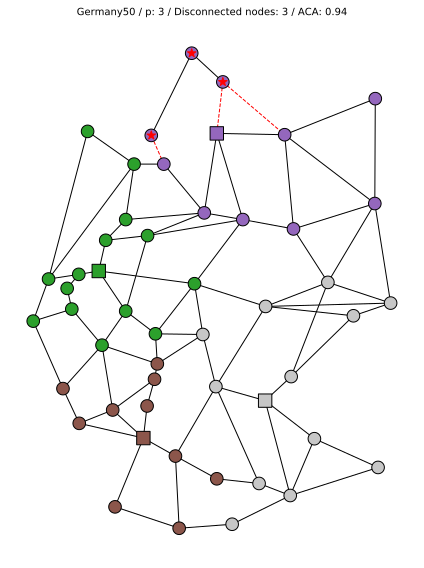

done for p 4
found 1360 variables in the solution
done for p 5
found 1360 variables in the solution
done for p 6
found 1360 variables in the solution


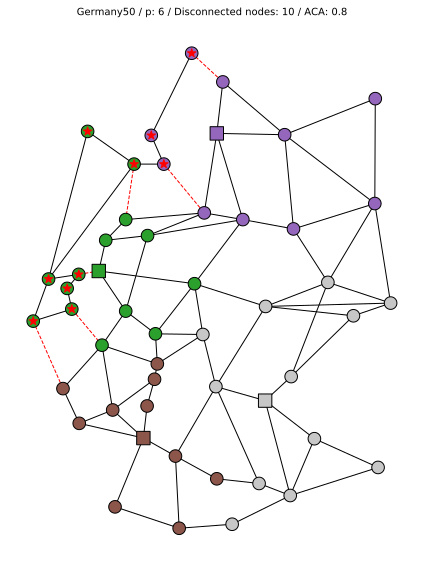

done for p 7
found 1360 variables in the solution
done for p 8
found 1360 variables in the solution
done for p 9
found 1360 variables in the solution


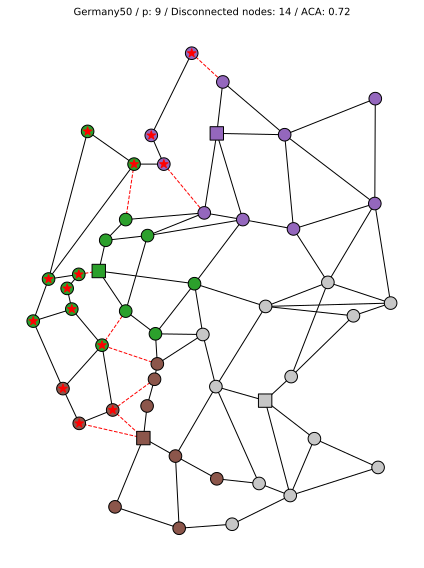

done for p 10
found 1360 variables in the solution
done for p 11
found 1360 variables in the solution
done for p 12
found 1360 variables in the solution


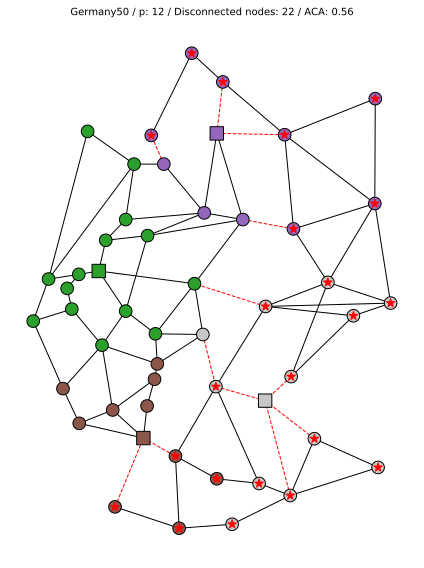

In [6]:
solutions_clsd = {}
aca_values = []
for p in range(pmin, pmax+1):
    
    solutions_clsd[p] = clsd(graph, variables_rpp, p)
    aca_value = (solutions_clsd[p]['sum_connected'] + budget) / graph.number_of_nodes()
    aca_values.append(aca_value)
    
    # only plots the graph representation for odd values of p
    if p % 3 != 0:
        continue
    
    plt.figure(figsize=fig_size[topology])
    pos = nx.get_node_attributes(graph, 'pos')
    plt.axis('off')

    plt.title('{} / p: {} / Disconnected nodes: {} / ACA: {}'.format(topology, 
                                                                  p, 
                                                                  int(graph.number_of_nodes() - budget - solutions_clsd[p]['sum_connected']),
                                                                  aca_value),
              fontsize=10)

    cmap = matplotlib.cm.get_cmap('tab20')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=graph.number_of_nodes())
    
    # drawing network edges
    normal_edges = []
    critical_edges = []
    for i,j in graph.edges():
        if solutions_clsd[p][f'x_{i}_{j}'] == 0: # not a critical edge
            normal_edges.append((i,j))
        else:
            critical_edges.append((i, j))
    nx.draw_networkx_edges(graph, pos, normal_edges)
    nx.draw_networkx_edges(graph, pos, critical_edges, edge_color='r', style='--')

    disconnected_nodes = {}
    dni = 1
    for q in graph.nodes(): # for all the nodes
        if variables_rpp[f'r_{q}'] == 0 and solutions_clsd[p][f'v_{q}'] == 0:
            disconnected_nodes[q] = str(dni)
            dni += 1
        if variables_rpp[f'r_{q}'] == 1: # if a node was selected as DC
            nodes_x = []
            nodes_y = []
            for s in graph.nodes(): # for all the nodes
                if q != s and variables_rpp[f'y_{q}_{s}'] == 1: # node s is using node q as DC
                    nodes_x.append(pos[s][0])
                    nodes_y.append(pos[s][1])
            plt.scatter(pos[q][0], pos[q][1], color=cmap(norm(float(q))), alpha=1., marker='s', linewidths=1., edgecolors='black', s=180.)
            plt.scatter(nodes_x, nodes_y, color=cmap(norm(float(q))), alpha=1., marker='o', linewidths=1., edgecolors='black', s=160.)
    
#     nx.draw_networkx_labels(graph, {key: (p[0], p[1]+.2) for key, p in pos.items()}, disconnected_nodes, font_color='red')
    plt.scatter([p[0] for key, p in pos.items() if key in disconnected_nodes],
                [p[1] for key, p in pos.items() if key in disconnected_nodes], marker='*', color='red', s=80)

    plt.tight_layout()
#     plt.savefig('./results/{topology}_{budget}.{export_format}')
    plt.show()
    plt.close()

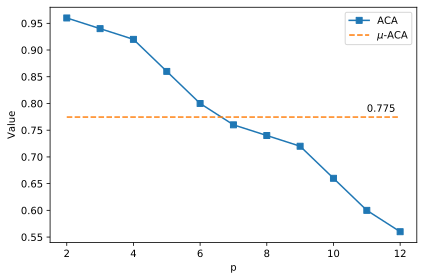

In [7]:
plt.figure()

plt.plot(range(pmin, pmax+1), aca_values, label='ACA', marker='s')
plt.plot(range(pmin, pmax+1), np.tile(np.mean(aca_values), len(aca_values)), label='$\mu$-ACA', linestyle='--')
plt.text(pmax-1, np.mean(aca_values)+.01, '{:.3f}'.format(np.mean(aca_values)))
plt.xlabel('p')
plt.ylabel('Value')
plt.legend(loc=1)
plt.tight_layout()
plt.show()